# **Deep Hedging**
# Buchkov Viacheslav

In [1]:
import abc
import math
import os
import random
import sys
from functools import lru_cache
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# You may add any imports you need
from torch.cuda.amp import GradScaler

RANDOM_SEED = 12

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(RANDOM_SEED)

In [3]:
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [4]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

ROOT_PATH = Path("dataset")
PATH = Path("/content/gdrive/MyDrive/")
N_DAYS = 5

Mounted at /content/gdrive


In [5]:
data = pd.read_pickle(PATH / "data.pkl")
data["rub_rate"] = data["rub_rate"] / 100
data.dropna(inplace=True)
data

,bid,ask,rub_rate,usd_rate
timestamp,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,0.081265,0.006720
2017-01-03 07:01:00+00:00,61.010855,61.068045,0.081265,0.006720
2017-01-03 07:02:00+00:00,61.037220,61.069850,0.081265,0.006720
2017-01-03 07:03:00+00:00,61.011955,61.048690,0.081265,0.006720
2017-01-03 07:04:00+00:00,61.021250,61.052835,0.081265,0.006720
...,...,...,...,...
2019-05-17 20:45:00+00:00,64.751605,64.781930,0.066051,0.026054
2019-05-17 20:46:00+00:00,64.751060,64.770000,0.066051,0.026054
2019-05-17 20:47:00+00:00,64.738785,64.757005,0.066051,0.026054


In [6]:
import abc

import numpy as np

from enum import Enum


class PositionSide(Enum):
    LONG = 1
    SHORT = -1



class Instrument:
    CALENDAR_DAYS: int = 365

    def __init__(self):
        pass

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    @staticmethod
    def discount_factor(rate: float, term: float) -> float:
        return np.exp(-rate * term)

    @abc.abstractmethod
    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def pv_coupons(self) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def price(self, spot_start: [float, list[float], None] = None) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def payoff(self, spot: [np.array, float]) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.LONG, other)])

    def __sub__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.SHORT, other)])


class StructuredNote:
    def __init__(self, instruments: [list[tuple[PositionSide, Instrument]], None] = None):
        if instruments is not None:
            self.instruments = instruments
        else:
            self.instruments = []

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    def coupon(self, frequency: float = 0., commission: float = 0., *args, **kwargs) -> float:
        return sum([instrument.coupon(frequency, commission) for _, instrument in self.instruments])

    def __add__(self, other: Instrument):
        return self.instruments.append((PositionSide.LONG, other))

    def __sub__(self, other: Instrument):
        return self.instruments.append((PositionSide.SHORT, other))

    def price(self) -> float:
        return sum([side.value * instrument.price() + instrument.pv_coupons() for side, instrument in self.instruments])

    def payoff(self, spot_paths: np.array) -> float:
        return sum([side.value * instrument.payoff(spot_paths) for side, instrument in self.instruments])

    def __repr__(self):
        sp_str = f"StructuredNote of:\n"
        for side, instrument in self.instruments:
            sp_str += f"* {side} -> {instrument}\n"
        return sp_str

    def __str__(self):
        return self.__repr__()


In [7]:
import numpy as np


class Forward(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float,
            *args,
            **kwargs
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        if spot_price is None:
            spot_price = self.spot_price
        return spot_price * self.discount_factor(rate=-self.rates_difference, term=self.term)

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return spot - self.strike

    def __repr__(self):
        return f"Forward(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"


In [8]:
import numpy as np


class EuropeanCall(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float,
            *args,
            **kwargs
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        return self.spot_price

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return max(spot - self.strike, 0)

    def __repr__(self):
        return f"EuropeanCall(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"

In [9]:
# from src.base.instrument import Instrument
# from src.forward.forward import Forward


def create_instrument(period_df: pd.DataFrame) -> Instrument:
    start = period_df.loc[period_df.index.min()]
    return EuropeanCall(
        rates_difference=start["rub_rate"] - start["usd_rate"],
        spot_price=start["ask"],
        term=N_DAYS / 365
    )

In [10]:
import datetime as dt

start_date = data.index.min()
end_date = start_date + dt.timedelta(days=N_DAYS)
data[(data.index >= data.index.min()) & (data.index <= end_date)]

,bid,ask,rub_rate,usd_rate
timestamp,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,0.081265,0.006720
2017-01-03 07:01:00+00:00,61.010855,61.068045,0.081265,0.006720
2017-01-03 07:02:00+00:00,61.037220,61.069850,0.081265,0.006720
2017-01-03 07:03:00+00:00,61.011955,61.048690,0.081265,0.006720
2017-01-03 07:04:00+00:00,61.021250,61.052835,0.081265,0.006720
...,...,...,...,...
2017-01-06 20:45:00+00:00,59.593105,59.609935,0.080748,0.004992
2017-01-06 20:46:00+00:00,59.606395,59.632965,0.080748,0.004992
2017-01-06 20:47:00+00:00,59.601450,59.636325,0.080748,0.004992


In [11]:
call = create_instrument(data[(data.index >= data.index.min()) & (data.index <= end_date)])
call

EuropeanCall(strike=61.0165, term=0.0136986301369863, spot_ref=61.0165)

## Dataset.

# Env

In [12]:
# from typing import Type, Union

# import gym
# from gym import spaces

# import numpy as np
# import pandas as pd
# pd.options.mode.chained_assignment = None

# N_DAYS = 5


# class DerivativeEnv(gym.Env):
#     METADATA = {'render.modes': ['human']}

#     BID_COLUMN: str = "bid"
#     ASK_COLUMN: str = "ask"
#     RATE_DOMESTIC_COLUMN: str = "rub_rate"
#     RATE_FOREIGN_COLUMN: str = "usd_rate"

#     TRADING_DAYS: int = 252

#     def __init__(
#             self,
#             instrument_cls: Type[Instrument],
#             n_days: int = N_DAYS,
#             path: Path = PATH,
#             data: Union[pd.DataFrame, None] = None,
#             random_seed: Union[int, None] = None,
#             device: Union[str, None] = None
#     ):
#         # Internal attributes
#         self.instrument_cls = instrument_cls
#         self.n_days = n_days

#         self.random_seed = random_seed

#         self.device = self._get_device() if device is None else device

#         self.data = self._create_df(path) if data is None else data.copy()
#         self.data.dropna(inplace=True)

#         self.data["time_diff"] = self.data.index.to_series().diff()
#         self.data.loc[self.data.index[0], "time_diff"] = pd.to_timedelta("0 days 00:00:00")
#         self.data["time_diff"] = self.data["time_diff"].cumsum() / np.timedelta64(1, 'D') / 365

#         self.dt = self.get_average_dt()

#         self._last_point = self.data.shape[0] - self.data[self.data.index >= self.data.index.max() - dt.timedelta(days=self.n_days)].shape[0]

#         # RL attributes
#         self.action_space = spaces.Box(low=-5, high=5, dtype=np.float32)

#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1, 5), dtype=np.float32)

#         self._initialize()

#     def _get_device(self) -> torch.device:
#         if torch.backends.mps.is_available():
#             return torch.device('mps')
#         elif torch.cuda.is_available():
#             return torch.device('cuda')
#         else:
#             return torch.device('cpu')

#     def _initialize(self):
#         self.current_step = 0
#         self._pnl = 0
#         self.weights = torch.Tensor([0]).to(self.device)
#         self.pnl_path = []
#         self.diff_path = []

#         self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

#     def get_pnl(self, weights: torch.Tensor, spot: torch.Tensor) -> tuple[torch.Tensor, torch.float32]:
#         weights_diff = weights - self.weights

#         rates_diff = spot[:, 2] - spot[:, 3]

#         bought = torch.where(weights_diff > 0, weights_diff, 0)
#         sold = torch.where(weights_diff < 0, weights_diff, 0)

#         interest = (rates_diff * -weights) * self.dt

#         cash_outflow = (-spot[:, 1] * bought)
#         cash_inflow = (-spot[:, 0] * sold)

#         return (cash_outflow + cash_inflow + interest).unsqueeze(1)

#     def _create_instrument(self, period_df: pd.DataFrame) -> Instrument:
#         start = period_df.loc[period_df.index.min()]
#         return self.instrument_cls(
#             rates_difference=start["rub_rate"] - start["usd_rate"],
#             spot_price=start["ask"],
#             term=N_DAYS / 365
#         )

#     @staticmethod
#     def _create_df(path: Path) -> pd.DataFrame:
#         if "data.pkl" in os.listdir(path):
#             return pd.read_pickle(PATH / "data.pkl")
#         else:
#             pass

#     def _sample_trajectory(self) -> list[torch.Tensor, torch.Tensor, int]:
#         if self.random_seed is not None:
#             np.random.seed(self.random_seed)

#         idx = np.random.choice(np.arange(self._last_point), replace=True)
#         start_date = self.data.index[idx]
#         end_date = start_date + dt.timedelta(days=self.n_days)

#         features = self.data[(self.data.index >= start_date) & (self.data.index <= end_date)]
#         time_start = features.iloc[0, -1]
#         features["time_diff"] = features["time_diff"].apply(lambda x: x - time_start)
#         target = self._create_instrument(features).payoff(spot=features.ask.iloc[-1])

#         data = torch.Tensor(features.to_numpy()).to(torch.float32).to(self.device)
#         target_pnl = torch.Tensor([target]).to(torch.float32).to(self.device)
#         max_step = features.shape[0] - 2

#         return data, target_pnl, max_step

#     def _next_obs(self):
#         return self._trajectory_data[self.current_step, :].unsqueeze(0)

#     def get_average_dt(self):
#         return self.data.index.to_series().diff(1).mean() / (np.timedelta64(1, 'D') * self.TRADING_DAYS)

#     def step(self, action):
#         self.current_step += 1

#         reward = 0
#         done = 0

#         obs = self._next_obs()
#         if self.current_step == self._max_step:
#             action = torch.Tensor([0]).to(self.device)
#             self._pnl += self.get_pnl(weights=action, spot=obs)

#             diff = self._target_pnl - self._pnl
#             reward = -(diff) ** 2

#             self.pnl_path.append(self._pnl)
#             self.diff_path.append(diff)

#             self.current_step = 0
#             self._pnl = 0
#             self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

#             done = 1
#         else:
#             self._pnl += self.get_pnl(weights=action, spot=obs)
#             self.weights = action

#         return obs, reward, done, {}

#     def reset(self):
#         # Reset the state of the environment to an initial state
#         self._initialize()

#         return self._next_obs()

#     def render(self, mode='human', close=False):
#         print(self.pnl_path)
#         print(self.diff_path)

In [13]:
# env = DerivativeEnv(instrument_cls=Forward)

NameError: name 'DerivativeEnv' is not defined

In [ ]:
# obs = env.reset()
# obs

In [ ]:
# class BaselinePolicyForward(nn.Module):
#     def __init__(self, dt: float = env.dt):
#         super().__init__()

#         self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
#         self.dt = dt

#     def forward(self, spot: torch.Tensor, return_hidden: bool = False) -> torch.Tensor:
#         return torch.Tensor([1]).to(torch.float32).to(DEVICE)

In [ ]:
# baseline = BaselinePolicyForward().to(DEVICE)

In [ ]:
# baseline(obs)

In [ ]:
# obs = env.reset()
# done = 0
# while not done:
#   # action, _states = model.predict(obs)
#   action = baseline(obs.to(DEVICE))
#   obs, rewards, done, _ = env.step(action)
#   # env.render()

In [ ]:
# obs

In [ ]:
# obs[0][-1] * 365

In [ ]:
# rewards

# Model

In [21]:
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0

In [ ]:
# from typing import Type, Union

# import gym
# from gym import spaces

# import numpy as np
# import pandas as pd
# pd.options.mode.chained_assignment = None

# N_DAYS = 5


# class DerivativeEnv(gym.Env):
#     METADATA = {'render.modes': ['human']}

#     BID_COLUMN: str = "bid"
#     ASK_COLUMN: str = "ask"
#     RATE_DOMESTIC_COLUMN: str = "rub_rate"
#     RATE_FOREIGN_COLUMN: str = "usd_rate"

#     TRADING_DAYS: int = 252

#     def __init__(
#             self,
#             instrument_cls: Type[Instrument],
#             n_days: int = N_DAYS,
#             path: Path = PATH,
#             data: Union[pd.DataFrame, None] = None,
#             random_seed: Union[int, None] = None,
#             device: Union[str, None] = None
#     ):
#         # Internal attributes
#         self.instrument_cls = instrument_cls
#         self.n_days = n_days

#         self.random_seed = random_seed

#         self.device = self._get_device() if device is None else device

#         self.data = self._create_df(path) if data is None else data.copy()
#         self.data.dropna(inplace=True)

#         self.data["time_diff"] = self.data.index.to_series().diff()
#         self.data.loc[self.data.index[0], "time_diff"] = pd.to_timedelta("0 days 00:00:00")
#         self.data["time_diff"] = self.data["time_diff"].cumsum() / np.timedelta64(1, 'D') / 365

#         self.dt = self.get_average_dt()

#         self._last_point = self.data.shape[0] - self.data[self.data.index >= self.data.index.max() - dt.timedelta(days=self.n_days)].shape[0]

#         # RL attributes
#         self.action_space = spaces.Box(low=-5, high=5, dtype=np.float32)

#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1, 5), dtype=np.float32)

#         self._initialize()

#     def _get_device(self) -> torch.device:
#         if torch.backends.mps.is_available():
#             return torch.device('mps')
#         elif torch.cuda.is_available():
#             return torch.device('cuda')
#         else:
#             return torch.device('cpu')

#     def _initialize(self):
#         self.current_step = 0
#         self._pnl = 0
#         self.weights = np.array([0])
#         self.pnl_path = []
#         self.diff_path = []

#         self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

#     def get_pnl(self, weights: torch.Tensor, spot: torch.Tensor) -> tuple[torch.Tensor, torch.float32]:
#         weights_diff = weights - self.weights

#         rates_diff = spot[2] - spot[3]

#         bought = np.where(weights_diff > 0, weights_diff, 0)
#         sold = np.where(weights_diff < 0, weights_diff, 0)

#         interest = (rates_diff * -weights) * self.dt

#         cash_outflow = (-spot[1] * bought)
#         cash_inflow = (-spot[0] * sold)

#         return (cash_outflow + cash_inflow + interest)[0]

#     def _create_instrument(self, period_df: pd.DataFrame) -> Instrument:
#         start = period_df.loc[period_df.index.min()]
#         return self.instrument_cls(
#             rates_difference=start["rub_rate"] - start["usd_rate"],
#             spot_price=start["ask"],
#             term=N_DAYS / 365
#         )

#     @staticmethod
#     def _create_df(path: Path) -> pd.DataFrame:
#         if "data.pkl" in os.listdir(path):
#             return pd.read_pickle(PATH / "data.pkl")
#         else:
#             pass

#     def _sample_trajectory(self) -> list[torch.Tensor, torch.Tensor, int]:
#         if self.random_seed is not None:
#             np.random.seed(self.random_seed)

#         idx = np.random.choice(np.arange(self._last_point), replace=True)
#         start_date = self.data.index[idx]
#         end_date = start_date + dt.timedelta(days=self.n_days)

#         features = self.data[(self.data.index >= start_date) & (self.data.index <= end_date)]
#         time_start = features.iloc[0, -1]
#         features["time_diff"] = features["time_diff"].apply(lambda x: x - time_start)
#         target = self._create_instrument(features).payoff(spot=features.ask.iloc[-1])

#         data = features.to_numpy()
#         target_pnl = target
#         max_step = features.shape[0] - 2

#         return data, target_pnl, max_step

#     def _next_obs(self):
#         return self._trajectory_data[self.current_step, :]

#     def get_average_dt(self):
#         return self.data.index.to_series().diff(1).mean() / (np.timedelta64(1, 'D') * self.TRADING_DAYS)

#     def step(self, action):
#         self.current_step += 1

#         reward = 0
#         done = 0

#         obs = self._next_obs()

#         # print(self._pnl, self.get_pnl(weights=action, spot=obs))
#         if self.current_step == self._max_step:
#             action = np.array([0])
#             self._pnl += self.get_pnl(weights=action, spot=obs)
#             # print(self._pnl)

#             # print("________")

#             diff = self._target_pnl - self._pnl
#             # print("***")
#             # print(diff)
#             # print("***")
#             reward = -(diff) ** 2

#             self.pnl_path.append(self._pnl)
#             self.diff_path.append(diff)

#             self.current_step = 0
#             self._pnl = 0
#             self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

#             done = 1
#         else:
#             self._pnl += self.get_pnl(weights=action, spot=obs)

#         self.weights = action

#         return obs, reward, done, {}

#     def reset(self):
#         # Reset the state of the environment to an initial state
#         self._initialize()

#         return self._next_obs()

#     def render(self, mode='human', close=False):
#         print(self.pnl_path)
#         print(self.diff_path)

In [14]:
from typing import Type, Union

import gym
from gym import spaces

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

N_DAYS = 5


class DerivativeEnv(gym.Env):
    METADATA = {'render.modes': ['human']}

    BID_COLUMN: str = "bid"
    ASK_COLUMN: str = "ask"
    RATE_DOMESTIC_COLUMN: str = "rub_rate"
    RATE_FOREIGN_COLUMN: str = "usd_rate"

    TRADING_DAYS: int = 252

    def __init__(
            self,
            instrument_cls: Type[Instrument],
            n_days: int = N_DAYS,
            path: Path = PATH,
            data: Union[pd.DataFrame, None] = None,
            random_seed: Union[int, None] = None,
            device: Union[str, None] = None
    ):
        # Internal attributes
        self.instrument_cls = instrument_cls
        self.n_days = n_days

        self.random_seed = random_seed

        self.device = self._get_device() if device is None else device

        self.data = self._create_df(path) if data is None else data.copy()
        self.data.dropna(inplace=True)

        self.data["time_diff"] = self.data.index.to_series().diff()
        self.data.loc[self.data.index[0], "time_diff"] = pd.to_timedelta("0 days 00:00:00")
        self.data["time_diff"] = self.data["time_diff"].cumsum() / np.timedelta64(1, 'D') / 365

        self.dt = self.get_average_dt()

        self._last_point = self.data.shape[0] - self.data[self.data.index >= self.data.index.max() - dt.timedelta(days=self.n_days)].shape[0]

        # RL attributes
        self._initialize()

        self.action_space = spaces.Box(low=-5, high=5, shape=(self._trajectory_data.shape[0] - 2,), dtype=np.float32)

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self._trajectory_data.shape, dtype=np.float32)

    def _get_device(self) -> torch.device:
        if torch.backends.mps.is_available():
            return torch.device('mps')
        elif torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')

    def _initialize(self):
        self._pnl = 0
        self.weights = np.array([0])
        self.pnl_path = []
        self.diff_path = []

        self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

    def _create_instrument(self, period_df: pd.DataFrame) -> Instrument:
        start = period_df.loc[period_df.index.min()]
        return self.instrument_cls(
            rates_difference=start["rub_rate"] - start["usd_rate"],
            spot_price=start["ask"],
            term=N_DAYS / 365
        )

    @staticmethod
    def _create_df(path: Path) -> pd.DataFrame:
        if "data.pkl" in os.listdir(path):
            return pd.read_pickle(PATH / "data.pkl")
        else:
            pass

    def _sample_trajectory(self) -> list[torch.Tensor, torch.Tensor, int]:
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        idx = np.random.choice(np.arange(self._last_point), replace=True)
        start_date = self.data.index[idx]
        end_date = start_date + dt.timedelta(days=self.n_days)

        features = self.data[(self.data.index >= start_date) & (self.data.index <= end_date)]
        time_start = features.iloc[0, -1]
        features["time_diff"] = features["time_diff"].apply(lambda x: x - time_start)
        target = self._create_instrument(features).payoff(spot=features.ask.iloc[-1])

        data = features.to_numpy()
        target_pnl = target
        max_step = features.shape[0] - 2

        return data, target_pnl, max_step

    def get_average_dt(self):
        return self.data.index.to_series().diff(1).mean() / (np.timedelta64(1, 'D') * self.TRADING_DAYS)

    def step(self, action):
        diff = self._target_pnl - self.get_pnl(weights=action, spot=self._trajectory_data)
        reward = -(diff) ** 2

        self.pnl_path.append(self._pnl)
        self.diff_path.append(diff)

        self._trajectory_data, self._target_pnl, self._max_step = self._sample_trajectory()

        done = 1

        return self._trajectory_data, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self._initialize()

        return self._trajectory_data

    def get_pnl(self, weights: torch.Tensor, spot: torch.Tensor) -> tuple[torch.Tensor, torch.float32]:
        weights_all = np.concatenate([np.zeros((1,)), weights, np.zeros((1,))])
        weights_diff = np.diff(weights_all, n=1)

        rates_diff = spot[:, 2] - spot[:, 3]

        bought = np.where(weights_diff > 0, weights_diff, 0)
        sold = np.where(weights_diff < 0, weights_diff, 0)

        interest = (rates_diff * -weights_all * self.dt).sum()

        cash_outflow = (-spot[1:, 1] * bought).sum()
        cash_inflow = (-spot[1:, 0] * sold).sum()

        return cash_outflow + cash_inflow + interest

    def render(self, mode='human', close=False):
        print(self.pnl_path)
        print(self.diff_path)

In [17]:
env = DerivativeEnv(data=data.resample("30 min").ffill(), instrument_cls=Forward)


class BaselinePolicyForward(nn.Module):
    def __init__(self, dt: float = env.dt):
        super().__init__()

        self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
        self.dt = dt

    def forward(self, spot: torch.Tensor, return_hidden: bool = False) -> torch.Tensor:
        return torch.Tensor([1] * (spot.shape[0] - 2)).to(torch.float32).to(DEVICE)

baseline = BaselinePolicyForward().to(DEVICE)

In [18]:
env = DerivativeEnv(data=data.resample("30 min").ffill(), instrument_cls=Forward)
base_diffs = []
obs = env.reset()
for i in range(100):
    done = False
    while not done:
        obs = torch.Tensor(obs).to(DEVICE)
        action = baseline(obs)
        obs, reward, done, info = env.step(action.detach().cpu().numpy())
        if reward != 0:
            base_diffs.append(reward)

In [19]:
base_diffs

[-0.0008219930435403051,
 -0.004929926275425361,
 -0.00599437165091662,
 -0.0036455320975695197,
 -4.071444159653135e-05,
 -0.0003568200674110668,
 -0.0004777466194751316,
 -0.0018704675212936474,
 -0.00021499866386950054,
 -0.0090907910656847,
 -0.001071376732675414,
 -0.00031429832497954633,
 -5.1102691993943355e-05,
 -0.0008688682730412221,
 -0.0010702303130128079,
 -0.0012751822729704107,
 -0.0016228661828039752,
 -0.00041623805679836813,
 -0.0002908078948283686,
 -0.00011729108535508116,
 -0.0011798050271239681,
 -0.00018004591194742032,
 -0.0020742815131147684,
 -0.0010627636483757736,
 -0.000430556276792921,
 -0.002223574009984417,
 -0.0370723063184677,
 -5.4955278890646096e-05,
 -0.0003726604952570458,
 -0.00040177544739912046,
 -0.0004480364855911025,
 -0.000728838348943254,
 -0.0012653613897517157,
 -1.267000086645348e-06,
 -0.000505485560769487,
 -8.009404770073783e-05,
 -0.024311793615769017,
 -0.1032993972179631,
 -0.00038504718399324194,
 -0.0030096733651641273,
 -0.00556

In [ ]:
!pip install sb3-contrib

In [23]:
from stable_baselines3.common.vec_env import DummyVecEnv
# from sb3_contrib import RecurrentPPO
# from stable_baselines3 import PPO
# from stable_baselines3 import PPO
from stable_baselines3 import SAC

env = DummyVecEnv([lambda: DerivativeEnv(data=data.resample("30 min").ffill(), instrument_cls=Forward)])

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1_000_000)

vec_env = model.get_env()
obs = vec_env.reset()
diffs = []
for i in range(10_000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    if reward != 0:
        diffs.append(reward)
    # vec_env.render()
    # VecEnv resets automatically
    # if done:
    #   obs = env.reset()

env.close()

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    n_updates       | 998471    |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 998576    |
|    fps             | 62        |
|    time_elapsed    | 15905     |
|    total_timesteps | 998576    |
| train/             |           |
|    actor_loss      | 102       |
|    critic_loss     | 1.64e+04  |
|    ent_coef        | 3.87e-34  |
|    ent_coef_loss   | -1.81e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 998475    |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 998580    |
|    fps             | 62        |
|    time_elapsed    | 15905     |
|    total_timesteps | 998580    |
| train/             |           |
|    actor_loss      | 102       |
|    critic_loss     | 1.2e+04   |
|    ent_coef        | 3.87e-34  |
|    ent_coef_loss   | -1.82e+04 |
|   

In [24]:
np.stack(diffs).mean()

-135.39175

In [25]:
np.stack(diffs).std()

135.83582

In [26]:
diffs

[array([-64.58577], dtype=float32),
 array([-114.52223], dtype=float32),
 array([-170.2782], dtype=float32),
 array([-45.776108], dtype=float32),
 array([-111.76326], dtype=float32),
 array([-0.8694862], dtype=float32),
 array([-60.15864], dtype=float32),
 array([-140.90479], dtype=float32),
 array([-47.89411], dtype=float32),
 array([-371.79944], dtype=float32),
 array([-102.546], dtype=float32),
 array([-195.14526], dtype=float32),
 array([-134.12578], dtype=float32),
 array([-115.107994], dtype=float32),
 array([-11.971116], dtype=float32),
 array([-112.256485], dtype=float32),
 array([-209.03435], dtype=float32),
 array([-56.802685], dtype=float32),
 array([-120.44781], dtype=float32),
 array([-8.931483], dtype=float32),
 array([-185.13094], dtype=float32),
 array([-113.49147], dtype=float32),
 array([-61.825287], dtype=float32),
 array([-49.94131], dtype=float32),
 array([-117.897224], dtype=float32),
 array([-5.087558], dtype=float32),
 array([-39.11937], dtype=float32),
 array([

In [27]:
action

array([[-2.5204327,  3.5916233, -3.7208986, -3.242173 , -3.7257075,
         2.4819813,  2.7509794,  2.7309294, -3.9059143,  3.3165627,
         3.0398264,  3.8670816, -4.152221 ,  3.618988 , -3.373512 ,
         3.4575157, -3.5163844,  3.494668 , -3.8258152,  3.855875 ,
        -3.7804773,  3.5108538, -3.3856404,  3.9795027, -1.5971112,
        -3.8635292, -4.087487 , -3.775368 , -2.8908646, -2.5434544,
        -3.5735729,  3.7005997,  3.536026 , -3.5924067,  3.734664 ,
         4.0452747, -3.4541118, -4.013959 , -3.9797378,  4.0004253,
        -3.723464 , -3.3522506,  3.8829355,  3.6454859, -2.9651303,
         3.651863 ,  3.008421 ,  3.7383032,  3.8644114, -3.4842803,
         2.6012778, -2.883926 , -0.9133196, -3.690245 , -2.847746 ,
        -3.6325476,  3.6526499, -3.820848 , -3.7403033, -3.5679212,
        -3.5324187,  3.3819237,  3.8087978,  3.8335152, -3.5863228,
        -3.7650492, -3.4179907,  3.6981583,  3.6630983,  3.0901585,
        -3.0117579, -3.721447 ,  3.2227764,  3.1

In [ ]:
for i in range(10_000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

In [ ]:
np.array(base_diffs).mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.0048390376425193485

In [ ]:
action

array([[1.6811237]], dtype=float32)

In [ ]:
env = DummyVecEnv([lambda: DerivativeEnv(instrument_cls=Forward)])
model = SAC(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=100)
obs = env.reset()
for i in range(2000):
  action, _states = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  env.render()

In [ ]:
spot_dataset[0][0][-1][-1] * 365

tensor(5.)

In [ ]:
class NeuralHedger(nn.Module):
    def __init__(self, input_size: int = 5, num_layers: int = 3, hidden_size: int = 32, dt: float = AVERAGE_DT):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dt = dt

        self.lstm = nn.LSTM(input_size, self.hidden_size, num_layers=num_layers, batch_first=True)

        self.hedging_weights = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, spot: torch.Tensor, hidden: [(torch.Tensor), None] = None, return_hidden: bool = False) -> [
        torch.Tensor,
        (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device = spot.device
        if hidden is None:
            h_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
            c_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        elif len(hidden) != 2:
            raise ValueError(f"Expected two hidden state variables, got {len(hidden)}")
        else:
            h_t, c_t = hidden

        h_t, c_t = self.lstm(spot, (h_t, c_t))
        outputs = self.hedging_weights(h_t)[:, 1:-1, :].squeeze(2)

        if return_hidden:
            return outputs, (h_t, c_t)
        else:
            return outputs

    def get_pnl(self, spot: torch.Tensor) -> [torch.Tensor, torch.float32]:
        # hedging_weights = nn.Softmax()(self.forward(spot, return_hidden=False), dim=XXX)
        hedging_weights = self.forward(spot, return_hidden=False)
        return hedging_weights, get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)

    def get_metric(self, spot: torch.Tensor, target: torch.Tensor, lambda_: float = 0.5) -> torch.float32:
        hedging_weights = self.forward(spot, return_hidden=False)
        pnl = get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)
        pnl_diff = target - pnl
        loss = lambda_ * (pnl_diff ** 2).mean() + (1 - lambda_) * pnl_diff.std()
        return hedging_weights, pnl, loss

In [ ]:
hedger = NeuralHedger()
loader = DataLoader(spot_dataset, batch_size=32, shuffle=True, drop_last=True)

for feature, target in loader:
    print(feature.shape)
    pnl = hedger.get_metric(feature.to(torch.float32), target)
    break
pnl

torch.Size([32, 7201, 5])


(tensor([[0.0130, 0.0137, 0.0133,  ..., 0.0109, 0.0109, 0.0109],
         [0.0132, 0.0145, 0.0144,  ..., 0.0122, 0.0122, 0.0122],
         [0.0133, 0.0146, 0.0147,  ..., 0.0188, 0.0188, 0.0188],
         ...,
         [0.0133, 0.0145, 0.0145,  ..., 0.0169, 0.0169, 0.0169],
         [0.0133, 0.0146, 0.0148,  ..., 0.0189, 0.0189, 0.0189],
         [0.0130, 0.0140, 0.0135,  ..., 0.0111, 0.0111, 0.0111]],
        grad_fn=<SqueezeBackward1>),
 tensor([[-0.0056],
         [ 0.0019],
         [ 0.0111],
         [-0.0113],
         [-0.0063],
         [ 0.0003],
         [-0.0093],
         [ 0.0009],
         [ 0.0090],
         [-0.0045],
         [-0.0130],
         [-0.0117],
         [-0.0161],
         [ 0.0094],
         [-0.0086],
         [ 0.0067],
         [ 0.0004],
         [ 0.0090],
         [ 0.0058],
         [ 0.0152],
         [-0.0023],
         [-0.0093],
         [ 0.0092],
         [-0.0232],
         [-0.0109],
         [-0.0131],
         [-0.0055],
         [ 0.0066]

In [ ]:
# pnl.shape, target.shape

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader


def train_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                loader: DataLoader, tqdm_desc: str = "Model"):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    train_loss = 0.0
    model.train()
    scaler = GradScaler()
    for features, target_pnl in iterator:
        optimizer.zero_grad()

        features = features.to(device)
        target_pnl = target_pnl.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            _, model_pnl, loss = model.get_metric(features, target_pnl)
            # loss = criterion(target_pnl, model_pnl)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        train_loss += loss.item()

    train_loss /= len(loader.dataset)

    return train_loss


@torch.no_grad()
def validation_epoch(model: nn.Module, criterion: nn.Module,
                     loader: DataLoader, tqdm_desc: [str, None] = None):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    val_loss = 0.0
    preds = []
    weight_path = []
    pnl_path = []
    model.eval()
    for features, target_pnl in iterator:
        features = features.to(device)
        target_pnl = target_pnl.to(device)

        weights, model_pnl, loss = model.get_metric(features, target_pnl)

        # loss = criterion(target_pnl, model_pnl)
        pnl_path.append([target_pnl, model_pnl])
        val_loss += loss.item()

        # preds.append(pred.detach().cpu().numpy())
        weight_path.append(weights.detach().cpu().numpy())

    val_loss /= len(loader.dataset)

    return val_loss, weights, pnl_path

In [ ]:
from IPython.display import clear_output

def plot_losses(train_losses: list[float], val_losses: list[float]):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    # train_perplexities, val_perplexities = torch.exp(torch.tensor(train_losses)), torch.exp(torch.tensor(val_losses))

    # axs[1].plot(range(1, len(train_perplexities) + 1), train_perplexities, label='train')
    # axs[1].plot(range(1, len(val_perplexities) + 1), val_perplexities, label='val')
    # axs[1].set_ylabel('perplexity')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
from typing import Tuple, List, Optional, Any


def train(model: nn.Module, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
          train_loader: DataLoader, val_loader: DataLoader,
          num_epochs: int, print_logs: bool = True) -> Tuple[List[float], List[float]]:
    train_losses, val_losses = [], []
    criterion = nn.MSELoss().to(DEVICE)

    for epoch in range(1, num_epochs + 1):
        if print_logs:
            desc_train = f"Training {epoch}/{num_epochs}"
            desc_val = f"Validation {epoch}/{num_epochs}"
        else:
            desc_train, desc_val = None, None

        train_loss = train_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=desc_train
        )
        val_loss, weights, pnl_path = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=desc_val
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]
        plot_losses(train_losses, val_losses)

    return train_losses, val_losses, weights, pnl_path

In [ ]:
TEST_SIZE = 0.25

In [ ]:
train_data = data.resample("30 min").ffill()
time_split = train_data.index[int(train_data.index.shape[0] * (1 - TEST_SIZE))]
train_df, test_df = train_data[train_data.index <= time_split], train_data[train_data.index > time_split]
train_df.shape, test_df.shape

((31126, 4), (10374, 4))

In [ ]:
train_df.isna().any(), test_df.isna().any()

(bid         False
 ask         False
 rub_rate    False
 usd_rate    False
 dtype: bool,
 bid         False
 ask         False
 rub_rate    False
 usd_rate    False
 dtype: bool)

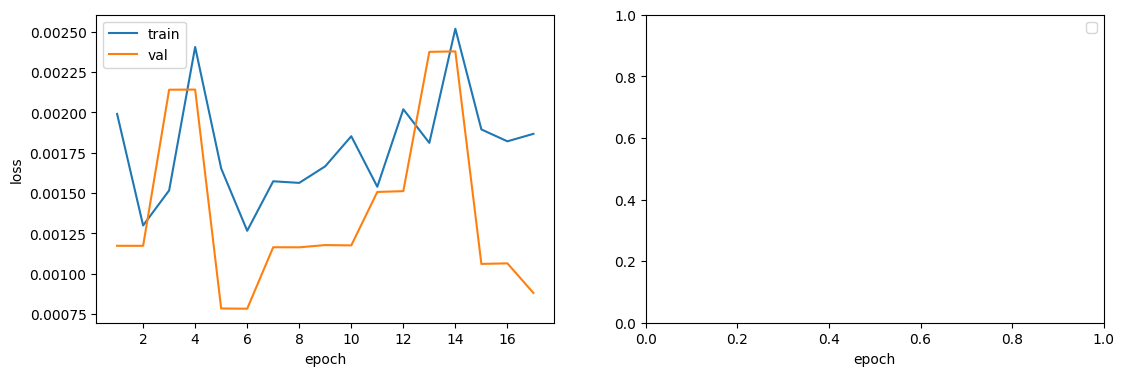

Training 18/100:  84%|████████▍ | 816/966 [00:32<00:06, 24.96it/s]

In [ ]:
hedger = NeuralHedger().to(DEVICE)

# train_set = SpotDataset(data=train_df, instrument_cls=EuropeanCall)
# val_set = SpotDataset(data=test_df, instrument_cls=EuropeanCall)

train_set = SpotDataset(data=train_df, instrument_cls=Forward)
val_set = SpotDataset(data=test_df, instrument_cls=Forward)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, drop_last=False)

# optimizer = torch.optim.SGD(hedger.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(hedger.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1)

train_losses, val_losses, weights, pnl_path = train(
    model=hedger,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    print_logs=True
)

In [ ]:
torch.save(hedger, PATH / "fwd_out_custom.pt")

In [ ]:
def assess_model(model: nn.Module, baseline: nn.Module) -> None:
    _, weights, pnl_path = validation_epoch(model, nn.MSELoss(), val_loader)
    _, _, baseline_path = validation_epoch(baseline, nn.MSELoss(), val_loader)
    print(weights)
    model_targets = torch.cat([x[0] for x in pnl_path])
    model_pnls = torch.cat([x[1] for x in pnl_path])

    baseline_targets = torch.cat([x[0] for x in baseline_path])
    baseline_pnls = torch.cat([x[1] for x in baseline_path])

    model_diff = model_targets - model_pnls
    baseline_diff = baseline_targets - baseline_pnls
    print(model_diff)

    print(f"Means: model = {model_diff.mean():.6f}, baseline = {baseline_diff.mean():.6f}")

    print(f"Stds: model = {model_diff.std():.6f}, baseline = {baseline_diff.std():.6f}")

    print(f"VaRs 5%: model = {torch.abs(torch.quantile(model_diff, 0.05)):.6f}, baseline = {torch.abs(torch.quantile(baseline_diff, 0.05)):.6f}")

In [ ]:
assess_model(hedger, baseline)

In [ ]:
val_loss, weights, pnl_path = validation_epoch(hedger, nn.MSELoss(), val_loader)
weights

tensor([[1.0353, 1.0066, 1.0024,  ..., 1.0016, 1.0016, 1.0016],
        [1.0332, 1.0047, 1.0005,  ..., 0.9999, 0.9999, 0.9999],
        [1.0349, 1.0062, 1.0019,  ..., 1.0009, 1.0009, 1.0009],
        ...,
        [1.0353, 1.0066, 1.0023,  ..., 1.0015, 1.0015, 1.0015],
        [1.0349, 1.0062, 1.0019,  ..., 1.0013, 1.0013, 1.0013],
        [1.0354, 1.0066, 1.0023,  ..., 1.0017, 1.0017, 1.0017]],
       device='cuda:0')

In [ ]:
weights.min(), weights.max()

In [ ]:
target_pnls = torch.cat([x[0] for x in pnl_path])
model_pnls = torch.cat([x[1] for x in pnl_path])

In [ ]:
target_pnls.mean() - model_pnls.mean()

In [ ]:
diff = target_pnls - model_pnls
target_pnls[diff.isnan()]

tensor([], device='cuda:0')

In [ ]:
(target_pnls - model_pnls).mean()

tensor(-0.0147, device='cuda:0')

In [ ]:
(target_pnls - model_pnls).std()

tensor(0.0480, device='cuda:0')

In [ ]:
target_pnls.std(), model_pnls.std()

(tensor(0.5869, device='cuda:0'), tensor(0.5152, device='cuda:0'))

In [ ]:
target_pnls.mean() * target_pnls.std(), model_pnls.mean() * model_pnls.std()

(tensor(0.0364, device='cuda:0'), tensor(0.0096, device='cuda:0'))

In [ ]:
target_pnls.shape

torch.Size([20629, 1])

In [ ]:
t_value = (target_pnls.mean() - model_pnls.mean()) / torch.sqrt(target_pnls.std() ** 2 / target_pnls.shape[0] + model_pnls.std() ** 2 / model_pnls.shape[0])
t_value

tensor(56.1847, device='cuda:0')

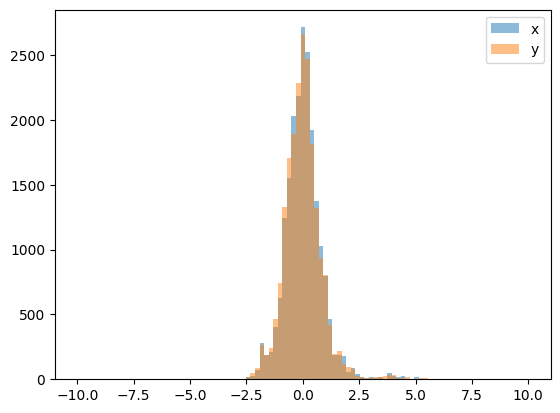

In [ ]:
from matplotlib import pyplot

bins = np.linspace(-10, 10, 100)

pyplot.hist(target_pnls.cpu().numpy(), bins, alpha=0.5, label='x')
pyplot.hist(model_pnls.cpu().numpy(), bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
val_loss

0.00028110694861994544

In [ ]:
for x, y in loader:
    print(x.shape)
    print(hedger(x.to(DEVICE)).shape)
    break

torch.Size([32, 121, 4])
torch.Size([32, 119])


In [ ]:
baseline = BaselineForward().to(DEVICE)
for x, y in loader:
    print(x.shape)
    print(baseline(x.to(DEVICE)).shape)
    break

torch.Size([32, 7201, 4])
torch.Size([32, 7199])


In [ ]:
baseline = BaselineForward().to(DEVICE)
val_loss, weights, pnl_path = validation_epoch(baseline, nn.MSELoss(), val_loader)
weights

In [ ]:
baseline_loader = DataLoader(val_set, batch_size=1, shuffle=True, drop_last=False)
for features, t_pnl in baseline_loader:
    break
features

tensor([[[6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02],
         [6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02

In [ ]:
features.shape

torch.Size([1, 241, 4])

In [ ]:
t_pnl

tensor([[0.1358]])

In [ ]:
features[:, -1, :]

tensor([[6.5673e+01, 6.5685e+01, 7.0504e-02, 2.0442e-02]])

In [ ]:
features[:, 0, :]

tensor([[6.5490e+01, 6.5507e+01, 6.7496e-02, 1.9747e-02]])

In [ ]:
hedger.get_pnl(features.to(DEVICE))

(tensor([[1.0354, 1.0066, 1.0024, 1.0018, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017,
          1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0017, 1.0018, 1.0018,
          1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018,
          1.0018, 1.0018, 1.0018, 1.0018, 1.0019, 1.0019, 1.0019, 1.0018, 1.0018,
          1.0018

In [ ]:
baseline_pnls = torch.cat([x[1] for x in pnl_path])
target_pnls = torch.cat([x[0] for x in pnl_path])
baseline_pnls

tensor([[ 0.0216],
        [-0.4163],
        [-0.1612],
        ...,
        [-0.0604],
        [-0.1710],
        [-0.5029]], device='cuda:0')

In [ ]:
(target_pnls - baseline_pnls).mean(), (target_pnls - model_pnls).mean()

(tensor(-0.0156, device='cuda:0'), tensor(-0.0147, device='cuda:0'))

In [ ]:
(target_pnls - baseline_pnls).std(), (target_pnls - model_pnls).std()

(tensor(0.0479, device='cuda:0'), tensor(1.0823, device='cuda:0'))

In [ ]:
torch.quantile(target_pnls - baseline_pnls, 0.05), torch.quantile(target_pnls - model_pnls, 0.05)

(tensor(-0.0859, device='cuda:0'), tensor(-1.8243, device='cuda:0'))

In [ ]:
(baseline_pnls - model_pnls).std()

tensor(1.0822, device='cuda:0')

In [ ]:
baseline_pnls.std(), model_pnls.std()

(tensor(0.8373, device='cuda:0'), tensor(0.8503, device='cuda:0'))

In [ ]:
torch.cat([baseline_pnls, target_pnls], dim=1)

tensor([[-0.7141, -0.6719],
        [ 0.2681,  0.2071],
        [ 0.0878,  0.0911],
        ...,
        [ 3.9414,  4.1302],
        [ 1.1528,  1.2512],
        [ 0.5623,  0.5775]], device='cuda:0')

In [ ]:
t_value = (baseline_pnls.mean() - model_pnls.mean()) / torch.sqrt(baseline_pnls.std() ** 2 / baseline_pnls.shape[0] + model_pnls.std() ** 2 / model_pnls.shape[0])
t_value

tensor(-0.0765, device='cuda:0')

## Option.

In [ ]:
import numpy as np


class EuropeanCall(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        return self.spot_price

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return max(spot - self.strike, 0)

    def __repr__(self):
        return f"EuropeanCall(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"

## Задание 1

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.

Советы:
1. Аугментации.
2. Оптимайзеры.
4. Регуляризация

In [ ]:
train_dataloader, test_dataloader = get_dataloaders(
    config=ExperimentConfig(),
    augmentation_hyperparams=AugmentationHyperparams()
)

NameError: name 'get_dataloaders' is not defined

### Модель

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, n_classes, kernel_size=3, stride=1, padding=1, dilation=1):
        super().__init__()
        self.accuracy_list = []

        self.pretrained = False

        # YOUR CODE HERE
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding,
                      dilation=dilation),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding,
                      dilation=dilation),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding,
                      dilation=dilation),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=stride, padding=padding,
                      dilation=dilation),
            nn.ReLU()
        )

        self.classifier = nn.Linear(in_features=128, out_features=n_classes)

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        feature_map = self.net(x)
        feature_vector = feature_map.mean(dim=(2, 3))
        logits = self.classifier(feature_vector)

        return logits

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get binary mask and save it to self.accuracy_list
        if target is not None:
            pred = torch.argmax(output, dim=-1)
            self.accuracy_list.extend((target == pred).tolist())

        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values in the dataset
        if reset:
            self.accuracy_list = []
            return None
        else:
            return torch.mean(torch.Tensor(self.accuracy_list))

### Тренировочный цикл

In [ ]:
from IPython.display import clear_output


def plot_losses(
        train_losses: List[float],
        val_losses: List[float],
        train_accs: List[float],
        val_accs: List[float]
):
    """
    Plot loss and perplexity of train and validation samples
    :param train_losses: list of train losses at each epoch
    :param val_losses: list of validation losses at each epoch
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss Dynamics')

    axs[1].plot(range(1, len(train_accs) + 1), train_accs, label='train')
    axs[1].plot(range(1, len(val_accs) + 1), val_accs, label='val')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy Dynamics')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def train_one_epoch(
        model,
        train_dataloader,
        criterion,
        optimizer,
        tqdm_desc: str = "Training"
):
    # YOUR CODE
    # Train your model here
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = train_dataloader
    else:
        iterator = tqdm(train_dataloader, desc=tqdm_desc)

    running_loss, running_acc = 0.0, 0.0
    model.train()
    model.get_accuracy(reset=True)
    scaler = GradScaler()
    for features, labels in iterator:
        optimizer.zero_grad()

        features = features.to(device)
        labels = labels.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(features, labels)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * features.shape[0]

    return running_loss / len(train_dataloader.dataset), model.get_accuracy().item()


def predict(model, test_dataloder, criterion, tqdm_desc: str = "Training"):
    # YOUR CODE
    # Validate your model here
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = test_dataloader
    else:
        iterator = tqdm(test_dataloader, desc=tqdm_desc)

    running_loss, running_acc = 0.0, 0.0
    model.eval()
    model.get_accuracy(reset=True)
    for features, labels in iterator:
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features, labels)

        loss = criterion(logits, labels)

        running_loss += loss.item() * features.shape[0]

    return running_loss / len(test_dataloader.dataset), model.get_accuracy().item()


def train(
        model,
        train_dataloader,
        test_dataloader,
        criterion,
        optimizer,
        device="cuda:0",
        n_epochs=10,
        scheduler=None,
        ckpt_path: Path = ExperimentConfig.CKPT_ROOT
):
    model.to(device)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(1, n_epochs + 1):
        # YOUR CODE
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...
        train_loss, train_acc = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            tqdm_desc=f'Training {epoch}/{n_epochs}'
        )
        val_loss, val_acc = predict(
            model=model,
            test_dataloder=test_dataloader,
            criterion=criterion,
            tqdm_desc=f'Validating {epoch}/{n_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]
        train_accs += [train_acc]
        val_accs += [val_acc]
        plot_losses(train_losses, val_losses, train_accs, val_accs)

        if model.pretrained:
            ckpt_name = f'{model.__class__.__name__}_pretrained_exp.pt'
        else:
            ckpt_name = f'{model.__class__.__name__}_exp.pt'
        torch.save(model.state_dict(), ckpt_path / ckpt_name)

In [ ]:
%%time
model = YourNet(n_classes=ExperimentConfig.N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=ExperimentConfig.LR)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ExperimentConfig.N_EPOCHS)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=ExperimentConfig.DEVICE,
    n_epochs=ExperimentConfig.N_EPOCHS,
    scheduler=scheduler
)

In [ ]:
class YourResNet18(torch.nn.Module):
    def __init__(self, n_classes, is_pretrained: bool = ExperimentConfig.IS_PRETRAINED):
        super().__init__()
        self.accuracy_list = []

        self.pretrained = is_pretrained

        # YOUR CODE HERE
        self.model = torchvision.models.resnet18(pretrained=is_pretrained, num_classes=n_classes)

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        logits = self.model(x)

        return logits

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get binary mask and save it to self.accuracy_list
        if target is not None:
            pred = torch.argmax(output, dim=-1)
            self.accuracy_list.extend((target == pred).tolist())

        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values in the dataset
        if reset:
            self.accuracy_list = []
            return None
        else:
            return torch.mean(torch.Tensor(self.accuracy_list))

In [ ]:
%%time

@dataclass
class AugmentationHyperparams:
    RESIZE_HEIGHT: Union[int, None] = None
    RESIZE_WIDTH: Union[int, None] = None
    RANDOM_CROP_SIZE: Union[int, None] = None
    RANDOM_CROP_PADDING: Union[int, None] = None
    FLIP_PROB: Union[float, None] = 0.25
    ROTATION_DEG: Union[float, None] = None
    JITTER_PARAM: Union[float, None] = None
    BRIGHTNESS: Union[float, None] = None
    CONTRAST: Union[float, None] = None
    SATURATION: Union[float, None] = None
    HUE: Union[float, None] = None


train_dataloader, test_dataloader = get_dataloaders(
    config=ExperimentConfig(),
    augmentation_hyperparams=AugmentationHyperparams()
)

model = YourResNet18(n_classes=ExperimentConfig.N_CLASSES)
# optimizer = torch.optim.Adam(model.parameters(), lr=ExperimentConfig.LR)
optimizer = torch.optim.SGD(model.parameters(), lr=ExperimentConfig.LR, momentum=0.9, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ExperimentConfig.N_EPOCHS)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=ExperimentConfig.DEVICE,
    n_epochs=ExperimentConfig.N_EPOCHS,
    scheduler=scheduler
)

In [ ]:
%%time

@dataclass
class AugmentationHyperparams:
    RESIZE_HEIGHT: Union[int, None] = None
    RESIZE_WIDTH: Union[int, None] = None
    RANDOM_CROP_SIZE: Union[int, None] = None
    RANDOM_CROP_PADDING: Union[int, None] = None
    FLIP_PROB: Union[float, None] = 0.25
    ROTATION_DEG: Union[float, None] = None
    JITTER_PARAM: Union[float, None] = None
    BRIGHTNESS: Union[float, None] = None
    CONTRAST: Union[float, None] = None
    SATURATION: Union[float, None] = None
    HUE: Union[float, None] = None


# #@dataclass
# class AugmentationHyperparams:
#     RESIZE_HEIGHT: Union[int, None] = None
#     RESIZE_WIDTH: Union[int, None] = None
#     RANDOM_CROP_SIZE: int = 32
#     RANDOM_CROP_PADDING: int = 4
#     FLIP_PROB: float = 0.5
#     ROTATION_DEG: float = 15
#     JITTER_PARAM: float = 0.25
#     BRIGHTNESS: float = 0.2
#     CONTRAST: float = 0.15
#     SATURATION: float = 0.15
#     HUE: float = 0.15

train_dataloader, test_dataloader = get_dataloaders(
    config=ExperimentConfig(),
    augmentation_hyperparams=AugmentationHyperparams()
)

model = YourNet(n_classes=ExperimentConfig.N_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr=ExperimentConfig.LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=ExperimentConfig.LR)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ExperimentConfig.N_EPOCHS)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=ExperimentConfig.DEVICE,
    n_epochs=ExperimentConfig.N_EPOCHS,
    scheduler=scheduler
)

In [ ]:
class YourMobileNet(torch.nn.Module):
    def __init__(self, n_classes, is_pretrained: bool = ExperimentConfig.IS_PRETRAINED):
        super().__init__()
        self.accuracy_list = []

        self.pretrained = is_pretrained

        # YOUR CODE HERE
        self.model = torchvision.models.mobilenet_v3_large(pretrained=is_pretrained, num_classes=n_classes)

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        logits = self.model(x)

        return logits

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get binary mask and save it to self.accuracy_list
        if target is not None:
            pred = torch.argmax(output, dim=-1)
            self.accuracy_list.extend((target == pred).tolist())

        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values in the dataset
        if reset:
            self.accuracy_list = []
            return None
        else:
            return torch.mean(torch.Tensor(self.accuracy_list))

In [ ]:
%%time
model = YourMobileNet(n_classes=ExperimentConfig.N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=ExperimentConfig.LR)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ExperimentConfig.N_EPOCHS)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=ExperimentConfig.DEVICE,
    n_epochs=ExperimentConfig.N_EPOCHS,
    scheduler=scheduler
)

In [ ]:
from enum import Enum


class PretrainMode(Enum):
    NOT_PRETRAINED = "NOT_PRETRAINED"
    LINEAR_PROBING = "LINEAR_PROBING"
    FINE_TUNING = "FINE_TUNING"

In [ ]:
class YourModel(torch.nn.Module):
    def __init__(
            self,
            n_classes: int,
            arhcitecture: nn.Module,
            pretrain_mode: PretrainMode = PretrainMode.LINEAR_PROBING
    ):
        super().__init__()
        self.accuracy_list = []

        # YOUR CODE HERE
        if pretrain_mode.NOT_PRETRAINED:
            self.pretrained = False
        else:
            self.pretrained = True

        if not pretrain_mode.NOT_PRETRAINED:
            self.model = torchvision.models.resnet50(pretrained=True)

            # Freezing weights
            if pretrain_mode.LINEAR_PROBING:
                for param in self.model.parameters():
                    param.requires_grad = False

            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features=in_features, out_features=n_classes)
        else:
            self.model = torchvision.models.resnet50(pretrained=False, num_classes=n_classes)

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        logits = self.model(x)

        return logits

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get binary mask and save it to self.accuracy_list
        if target is not None:
            pred = torch.argmax(output, dim=-1)
            self.accuracy_list.extend((target == pred).tolist())

        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values in the dataset
        if reset:
            self.accuracy_list = []
            return None
        else:
            return torch.mean(torch.Tensor(self.accuracy_list))

In [ ]:
class Experiment:
    def __init__(
            self,
            experiment_config: ExperimentConfig,
            augmentation_hyperparams: AugmentationHyperparams
    ):
        self.experiment_config = experiment_config
        self.augmentation_hyperparams = augmentation_hyperparams

    def run(self, model: nn.Module) -> nn.Module:
        train_dataloader, test_dataloader = get_dataloaders(
            config=self.experiment_config,
            augmentation_hyperparams=self.augmentation_hyperparams
        )

        if self.experiment_config.MOMENTUM is not None and self.experiment_config.WEIGHT_DECAY is not None:
            optimizer = torch.optim.SGD(
                model.parameters(),
                lr=self.experiment_config.LR,
                momentum=self.experiment_config.MOMENTUM,
                weight_decay=self.experiment_config.WEIGHT_DECAY
            )
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=self.experiment_config.LR)

        if self.experiment_config.LABEL_SMOOTHING is not None:
            criterion = torch.nn.CrossEntropyLoss(label_smoothing=self.experiment_config.LABEL_SMOOTHING)
        else:
            criterion = torch.nn.CrossEntropyLoss()

        eta_min = self.experiment_config.ETA_MIN if self.experiment_config.ETA_MIN is not None else 0.0
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.experiment_config.N_EPOCHS,
            eta_min=eta_min
        )

        train(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=ExperimentConfig.DEVICE,
            n_epochs=ExperimentConfig.N_EPOCHS,
            scheduler=scheduler
        )

        return model

In [ ]:
%%time

@dataclass
class ExperimentConfig:
    TRAIN_ROOT: str = ROOT_PATH / ROOT_PATH / 'train'
    VAL_ROOT: str = ROOT_PATH / ROOT_PATH / 'val'
    CKPT_ROOT: str = GDRIVE_ROOT_PATH

    # MEAN: Union[Tuple[float], None] = (0.485, 0.456, 0.406)
    # STD: Union[Tuple[float], None] = (0.229, 0.224, 0.225)

    MEAN: Union[Tuple[float], None] = None
    STD: Union[Tuple[float], None] = None

    N_EPOCHS: int = 100
    # LR: float = 1e-2
    LR: float = 0.5
    BATCH_SIZE: int = 32

    N_CLASSES = len(os.listdir(ROOT_PATH / ROOT_PATH / 'train'))

    NUM_WORKERS: int = 2

    MOMENTUM: Union[float, None] = 0.9
    WEIGHT_DECAY: Union[float, None] = 2e-05
    ETA_MIN: Union[float, None] = 0.00001
    LABEL_SMOOTHING: Union[float, None] = 0.1

    if torch.backends.mps.is_available():
        DEVICE = torch.device('mps')
    elif torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')

    IS_PRETRAINED: bool = False


@dataclass
class AugmentationHyperparams:
    RESIZE_HEIGHT: Union[int, None] = None
    RESIZE_WIDTH: Union[int, None] = None
    RANDOM_CROP_SIZE: int = None
    RANDOM_CROP_PADDING: int = None
    FLIP_PROB: float = None
    ROTATION_DEG: float = None
    JITTER_PARAM: float = None
    BRIGHTNESS: float = None
    CONTRAST: float = None
    SATURATION: float = None
    HUE: float = None


model = YourModel(n_classes=ExperimentConfig.N_CLASSES)
experiment = Experiment(
    experiment_config=ExperimentConfig(),
    augmentation_hyperparams=AugmentationHyperparams()
)
final_model = experiment.run(model)

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    model.get_accuracy(reset=True)
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            model(images, labels)
    accuracy = model.get_accuracy()
    return accuracy

In [ ]:
model = YourResNet50(n_classes=ExperimentConfig.N_CLASSES)
model.load_state_dict(torch.load(ExperimentConfig.CKPT_ROOT / f'{model.__class__.__name__}.pt'))

accuracy = evaluate_task(model, test_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

# Отчёт об экспериментах

* Описание проведенных вами экспериментов
* Ссылка на трекер (wandb или любой другой)
* Ваши мысли и наблюдения

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Советы:
1. Аугментации
2. Предобученные модели (https://pytorch.org/vision/stable/models.html)
3. Попробуйте сначала посмотреть качество исходной модели без дообучения, отталкиваться от него как baseline.

### Импортируйте предобученную модель в наш интерфейс

In [ ]:
%%time

@dataclass
class ExperimentConfig:
    TRAIN_ROOT: str = ROOT_PATH / ROOT_PATH / 'train'
    VAL_ROOT: str = ROOT_PATH / ROOT_PATH / 'val'
    CKPT_ROOT: str = GDRIVE_ROOT_PATH

    NORMALIZE: bool = True

    N_EPOCHS: int = 20
    # LR: float = 1e-2
    LR: float = 0.5
    BATCH_SIZE: int = 32

    N_CLASSES = len(os.listdir(ROOT_PATH / ROOT_PATH / 'train'))

    NUM_WORKERS: int = 2

    MOMENTUM: Union[float, None] = 0.9
    WEIGHT_DECAY: Union[float, None] = 2e-05
    ETA_MIN: Union[float, None] = 0.00001
    LABEL_SMOOTHING: Union[float, None] = 0.1

    if torch.backends.mps.is_available():
        DEVICE = torch.device('mps')
    elif torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')

    IS_PRETRAINED: bool = True


AugmentationHyperparams.RESIZE_HEIGHT = 224
AugmentationHyperparams.RESIZE_WIDTH = 224


@dataclass
class AugmentationHyperparams:
    RESIZE_HEIGHT: Union[int, None] = 224
    RESIZE_WIDTH: Union[int, None] = 224
    RANDOM_CROP_SIZE: int = None
    RANDOM_CROP_PADDING: int = None
    FLIP_PROB: float = None
    ROTATION_DEG: float = None
    JITTER_PARAM: float = None
    BRIGHTNESS: float = None
    CONTRAST: float = None
    SATURATION: float = None
    HUE: float = None


model = YourModel(
    n_classes=ExperimentConfig.N_CLASSES,
    pretrain_mode=PretrainMode.LINEAR_PROBING
)
experiment = Experiment(
    experiment_config=ExperimentConfig(),
    augmentation_hyperparams=AugmentationHyperparams
)
final_model = experiment.run(model)

In [ ]:
model = YourModel(
    arhcitecture=torchvision.models.resnet18,
    n_classes=ExperimentConfig.N_CLASSES,
    pretrain_mode=PretrainMode.LINEAR_PROBING
)
evaluate_task(model, test_dataloader)

### Валидация результатов задания

In [ ]:
model = YourResNet50(n_classes=ExperimentConfig.N_CLASSES)
model.load_state_dict(torch.load(ExperimentConfig.CKPT_ROOT / f'{model.__class__.__name__}.pt'))

accuracy = evaluate_task(model, test_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

# Отчёт об экспериментах

* Описание проведенных вами экспериментов
* Ссылка на трекер (wandb или любой другой)
* Ваши мысли и наблюдения